# Client Churn Prediction
### CRISP-DM Cycle 3
---

The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional bussiness case

## 0. PREPARATION

### 0.1 Planning

#### Input

- Predict wheter customer will be in churn;
- Dataset with sales records and customers info.

#### Output

- Which customer will be in churn;
- Churn rate of the company;
- Performance of the model;
- Action plan


#### Tasks

1. Which customer will be in churn:
    - What is the criterion?
        - Downtime
        - Time remaining until the contract ends


2. Current churn rate of the company:
    - Calculate churn rate
    - Calculate monthly churn rate and variation

3. Performance of the model:
    - Precision at K score
    - Recall at K score

4. Action plan:
    - Discount?
    - Voucher?
    - Deposit bonus?

### 0.2 Settings

In [1]:
# Settings imports
import os
import sys

from dotenv import load_dotenv

# Load .env file
env_path = "../.env"
load_dotenv(dotenv_path=env_path)

# Seed
seed = int(os.getenv("SEED"))

# Add path
path = os.getenv("HOMEPATH")

# Add path to sys.path
sys.path.append(path)

# Colors
colors_list = ["#DE9776", "#9192B3", "#3D8221", "#823F21", "#BFC2FF", "#97D77D"]

In [2]:
import helpers.functions.descriptive_statistics as ds
from helpers.classes.FeatureEngineering import FeatureEngineering
from helpers.classes.Queries import DuckQueries
from helpers.classes.FeatureSelection import FeatureSelection

### 0.4 Data

This dataset is avaliable [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

## 1. DATA DESCRIPTION

### 1.1 First Look

In [3]:
qb = DuckQueries()
conn = qb.get_connection(path + "/data/interim/churn.db")

query = qb.select("*").from_table("churn").limit(5).build()
result = conn.execute(query).df()
data_pandas = result  # For a future analysis
print(result.T)

                          0          1          2         3          4
row_number                1          2          3         4          5
customer_id        15634602   15647311   15619304  15701354   15737888
surname            Hargrave       Hill       Onio      Boni   Mitchell
credit_score            619        608        502       699        850
geography            France      Spain     France    France      Spain
gender               Female     Female     Female    Female     Female
age                      42         41         42        39         43
tenure                    2          1          8         1          2
balance                 0.0   83807.86   159660.8       0.0  125510.82
num_of_products           1          1          3         2          1
has_cr_card               1          0          1         0          1
is_active_member          1          1          0         0          1
estimated_salary  101348.88  112542.58  113931.57  93826.63    79084.1
exited

### 1.2 Data Dimensions

In [4]:
query = qb.shape("churn").build()
result = conn.execute(query).df()

rows = result.loc[0, "row_count"]
columns = result.loc[0, "column_count"]

print(f"Number of rows: {rows} \nNumber of columns: {columns}")

Number of rows: 10000 
Number of columns: 14


### 1.3 Check NA

In [5]:
query = qb.count_nulls_from_table("churn").build()
fetch = query = conn.execute(query).fetchone()[0]
result = conn.execute(f"SELECT {fetch} FROM churn").df()
print(result.T)

                  0
row_number        0
customer_id       0
surname           0
credit_score      0
geography         0
gender            0
age               0
tenure            0
balance           0
num_of_products   0
has_cr_card       0
is_active_member  0
estimated_salary  0
exited            0


Some features are categorial but has some encoding technique.

`is_active_member`, `exited` and `has_cr_card` should be strings

There's no NA in this dataset, however, there's a possibility that there are zeros in place of NAs

In [6]:
query = qb.count_zeros_from_table("churn").build()
fetch = query = conn.execute(query).fetchone()[0]
result = conn.execute(f"SELECT {fetch} FROM churn").df()
print(result.T)

                     0
row_number           0
customer_id          0
credit_score         0
age                  0
tenure             413
num_of_products      0
has_cr_card       2945
is_active_member  4849
exited            7963
balance           3617
estimated_salary     0


The balance columns has more than 1/3 of zero values, it doesn't mean that they're missing values but the DS team should get more information about this. The other zero values are from categorical features.

In [7]:
aux = data_pandas[data_pandas["balance"] == 0]
aux2 = aux["credit_score"].max()
aux3 = aux["credit_score"].min()
aux4 = aux["age"].max()
aux5 = aux["age"].min()
aux6 = aux["num_of_products"].max()
aux7 = aux["num_of_products"].min()

print(
    f"Max credit score: {aux2}\nMin credit score: {aux3}\nAge of older clients: {aux4}"
)
print(
    f"Age of youngest clients: {aux5}\nMax number of products: {aux6}\nMin number of products {aux7}"
)

Max credit score: 699
Min credit score: 619
Age of older clients: 42
Age of youngest clients: 39
Max number of products: 2
Min number of products 1


Apparently, it only indicates some accounts that, at the time of creating the dataset, had no deposited values.

### 1.4 Data Types

In [8]:
query = qb.column_types_from_table("churn").build()
result = conn.execute(query).df()
data_pandas = result
print(result.iloc[:, 0:2])

         column_name data_type
0         row_number    BIGINT
1        customer_id    BIGINT
2            surname   VARCHAR
3       credit_score    BIGINT
4          geography   VARCHAR
5             gender   VARCHAR
6                age    BIGINT
7             tenure    BIGINT
8            balance    DOUBLE
9    num_of_products    BIGINT
10       has_cr_card    BIGINT
11  is_active_member    BIGINT
12  estimated_salary    DOUBLE
13            exited    BIGINT


### 1.5 Descriptive Statistics

In [9]:
query = qb.select("*").from_table("churn").build()
df1 = conn.execute(query).df()
conn.close()

quantitative = df1.select_dtypes(include=["int64", "float64"])
quantitative.drop(
    columns=["customer_id", "row_number", "has_cr_card", "is_active_member", "exited"],
    inplace=True,
)

qualitative = df1[["is_active_member", "exited", "geography", "has_cr_card", "gender"]]
qualitative = qualitative.astype("str")

change_types = ["is_active_member", "exited", "has_cr_card"]

for column in change_types:
    qualitative.loc[:, column] = qualitative[column].replace({"1": "yes", "0": "no"})

#### 1.5.1 Quantitative

In [10]:
quantitative.describe(include="all")

credit_score           age        tenure        balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       num_of_products  estimated_salary  
count     10000.000000      10000.000000  
mean          1.530200     100090.239881  
std           0.581654      57510.492818  
min           1.000000         11.580000  
25%           1.000000      51002.110000  
50%           1.000000     100193.915000  
75%           2.000000     149388.247500  
max           4.000000     199992.480000

In [11]:
columns = [
    "age",
    "balance",
    "credit_score",
    "estimated_salary",
    "tenure",
    "num_of_products",
]

ds.multiple_boxplots(quantitative, columns, colors=colors_list)

Negative outliers in `credit_score` and positive outliers in `num_of_products` and `age`

#### 1.5.2 Qualitative

In [12]:
qualitative.describe(include="all")

is_active_member exited geography has_cr_card gender
count             10000  10000     10000       10000  10000
unique                2      2         3           2      2
top                 yes     no    France         yes   Male
freq               5151   7963      5014        7055   5457

In [13]:
ds.categorical_metrics(qualitative, "is_active_member")

absolute  percent %
is_active_member                     
yes                   5151      51.51
no                    4849      48.49

In [14]:
ds.categorical_metrics(qualitative, "geography")

absolute  percent %
geography                     
France         5014      50.14
Germany        2509      25.09
Spain          2477      24.77

In [15]:
ds.categorical_metrics(qualitative, "has_cr_card")

absolute  percent %
has_cr_card                     
yes              7055      70.55
no               2945      29.45

In [16]:
ds.categorical_metrics(qualitative, "gender")

absolute  percent %
gender                     
Male        5457      54.57
Female      4543      45.43

In [17]:
ds.categorical_metrics(qualitative, "exited")

absolute  percent %
exited                     
no          7963      79.63
yes         2037      20.37

Important informations:
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**;
- **70.6%** of the members **has credit card**;
- More than **50% of the clients** are **from France**

## 2. FEATURE ENGINEERING

### 2.1 Split Data and Feature Creating

In [18]:
fe = FeatureEngineering(seed=seed)
X_train, X_test, X_val, y_train, y_test, y_val, id_train, id_test, id_val = (
    fe.transform(df1)
)

### 2.2 Verify NaN

In [19]:
fe.report_na(X_train)

INFO - There are no NA values in any column.


In [20]:
fe.report_na(X_test)

INFO - There are no NA values in any column.


In [21]:
fe.report_na(X_val)

INFO - There are no NA values in any column.


### 2.3 Comparing Train, Test and Validation

In [22]:
# comp_path = path + "/reports/"
# fe.get_comparation_reports(X_train, X_test, (comp_path + "comp_report_train_test.html"))
# fe.get_comparation_reports(X_train, X_val, (comp_path + "comp_report_train_val.html"))
# fe.get_comparation_reports(X_test, X_val, (comp_path + "comp_report_test_val.html"))

## 3. FEATURE SELECTION

In [23]:
from helpers.classes.DataVisualizer import DataVisualizer


dv = DataVisualizer(X_train)
quantitative = X_train.select_dtypes(include=["int64", "float64"])

In [24]:
dv.distribution_analysis(quantitative.columns)

### Scaling

##### **How it works**
-  `StandardScaler`: Standardizes features by subtracting the mean and then scaling to unit variance. This transforms the data so that it has zero mean and a standard deviation of one.
-  `MinMaxScaler`: Transforms features by scaling each feature to a given range, usually 0 to 1, or -1 to 1 if there are negative values.
-  `RobustScaler`: Scales features using statistics that are robust to outliers, by subtracting the median and dividing by the interquartile range (IQR).

##### **When to use**
- `StandardScaler`: When your data approximately follows a normal distribution. It's usefull when algorithms are sensitive to the scale of the data, such as neural networks, clustering algorithms, and KNN.
- `MinMaxScaler`: When the scale of the feature is unknown or varies a lot. When you need a bounded scaling range. It's usefull when your data contains outliers and you do not want these extreme points to dominate the scaling.
- `RobustScaler`: When you have outliers and you want to reduce their influence. It's usefull when you have a small dataset or/and you want to avoid the influence of outliers.

##### Analyzing the distributions and the boxplots, we can draw some conclusions.

- `credit_score`: The distribution is close to a normal distribution, but there are some outliers. We can use `StandardScaler` if consider as a normal distribution or `MinMaxScaler` to normalize.

- `age`: Age is sensitive to outliers, so we can use `RobustScaler`.

- `tenure`: `MinMaxScaler` is the best option.

- `balance`: The distribution is not normal and has a lot of outliers. We can use `RobustScaler`.

- `estimated_salary`: The distribution is not normal and has a lot of outliers. We can use `RobustScaler`.

- `age_squared`: We can use `RobustScaler`.

- `balance_sqrt`: We can use `RobustScaler`.

- `credit_score_num_of_products`: `StandardScaler` if the distribution is normal or `MinMaxScaler` if not.

- `age_balance`: `RobustScaler` is the best option.

- `engagement_score`: `StandardScaler` is the best option.

- `customer_value_normalized`: There's not necessary to scale this feature.

- `product_density`: `RobustScaler` is the best option.

- `balance_salary_ratio`: `RobustScaler` is the best option.

- `credit_score_age_ratio`: `RobustScaler` is the best option.

- `tenure_age_ratio`: `RobustScaler` is the best option.

- `credit_salary_ratio`: `RobustScaler` is the best option.

### Encoding

- `One-Hot Encoding`: Creates a new column for each level of the categorical variable and assigns a value of 1 or 0 to each column in each row, depending on the presence of the attribute.
Use: Useful when categories do not have a natural order or hierarchy. This prevents the model from assigning an order where there isn't one, but can significantly increase the number of dimensions in the dataset.
Disadvantage: Can lead to a problem known as the "curse of dimensionality" in large datasets.

- `Label Encoding`: Converts each category value into an integer. Unique values are enumerated.
Use: Suitable for categorical variables with some natural order or hierarchy (ordinal), such as low, medium, high.
Disadvantage: Models may incorrectly interpret the data as having some form of numerical order or scale where it is not desired or true.

- `Binary Encoding`: Combines aspects of Label encoding and One-hot encoding. First, categorical values are converted into integers, and then those integers are converted into binary. Finally, the bits of the binary value are split into separate columns.
Use: When you have many categories, but One-hot encoding would add too many columns.
Frequency Encoding:
Description: Replaces categories with the frequency or percentage of observations in that category.
Use: Useful when the frequency of the categories is important for prediction and to avoid increasing dimensionality.

- `Frequency Encoding`: Replaces categories with the frequency or percentage of observations in that category.
Use: Useful when the frequency of the categories is important for prediction and to avoid increasing dimensionality.

##### Analyzing the features, we can draw some conclusions.

- `geography`: We can use `One-Hot Encoding`.
- `gender`: We can use `Label Encoding` or `One-Hot Encoding`.
- `tenure_group`: We can use `One-Hot Encoding`.
- `life_stage`: We can use `One-Hot Encoding` or `Label Encoding`.
- `balance_indicator`: We can use `One-Hot Encoding` or `Label Encoding`.
- `cs_category`: We can use `One-Hot Encoding` or `Label Encoding`.



### Log Transformation

##### We can use log transformation to reduce the skewness of the data.
- `balance`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `balance_sqrt`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `age_balance`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `age`: We can apply log transformation to this feature.
- `age_squared`: We can apply log transformation to this feature.

In [25]:
for dataframe in X_train, X_test, X_val:
    dataframe["balance"] = dataframe["balance"].apply(lambda x: 1 if x == 0 else x)
    dataframe["balance_sqrt"] = dataframe["balance_sqrt"].apply(
        lambda x: 1 if x == 0 else x
    )
    dataframe["age_balance"] = dataframe["age_balance"].apply(
        lambda x: 1 if x == 0 else x
    )

In [26]:
log_list = ["balance", "balance_sqrt", "age_balance", "age", "age_squared"]

ohe_list = [
    "geography",
    "tenure_group",
    "gender",
    "life_stage",
    "balance_indicator",
    "cs_category",
]

# Case 1
robust_scaler_list_c1 = [
    "age",
    "balance",
    "estimated_salary",
    "age_squared",
    "balance_sqrt",
    "age_balance",
    "product_density",
    "balance_salary_ratio",
    "credit_score_age_ratio",
    "tenure_age_ratio",
    "credit_salary_ratio",
]
minmax_scaler_list_c1 = ["tenure"]
standard_scaler_list_c1 = [
    "engagement_score",
    "credit_score",
    "credit_score_num_of_products",
]

# Case 2
robust_scaler_list_c2 = [
    "age",
    "balance",
    "estimated_salary",
    "age_squared",
    "balance_sqrt",
    "age_balance",
    "product_density",
    "balance_salary_ratio",
    "credit_score_age_ratio",
    "tenure_age_ratio",
    "credit_salary_ratio",
]
minmax_scaler_list_c2 = ["tenure", "credit_score_num_of_products"]
standard_scaler_list_c2 = ["engagement_score", "credit_score"]


# Case 3
robust_scaler_list_c3 = [
    "age",
    "balance",
    "estimated_salary",
    "age_squared",
    "balance_sqrt",
    "age_balance",
    "product_density",
    "balance_salary_ratio",
    "credit_score_age_ratio",
    "tenure_age_ratio",
    "credit_salary_ratio",
]
minmax_scaler_list_c3 = ["tenure", "credit_score", "credit_score_num_of_products"]
standard_scaler_list_c3 = ["engagement_score"]


# Case 4
robust_scaler_list_c4 = [
    "age",
    "balance",
    "estimated_salary",
    "age_squared",
    "balance_sqrt",
    "age_balance",
    "product_density",
    "balance_salary_ratio",
    "credit_score_age_ratio",
    "tenure_age_ratio",
    "credit_salary_ratio",
]
minmax_scaler_list_c4 = ["tenure", "credit_score"]
standard_scaler_list_c4 = ["engagement_score", "credit_score_num_of_products"]

INFO - Fitting ColumnTransformer
INFO - Fitting Model
INFO - Plotting feature importances


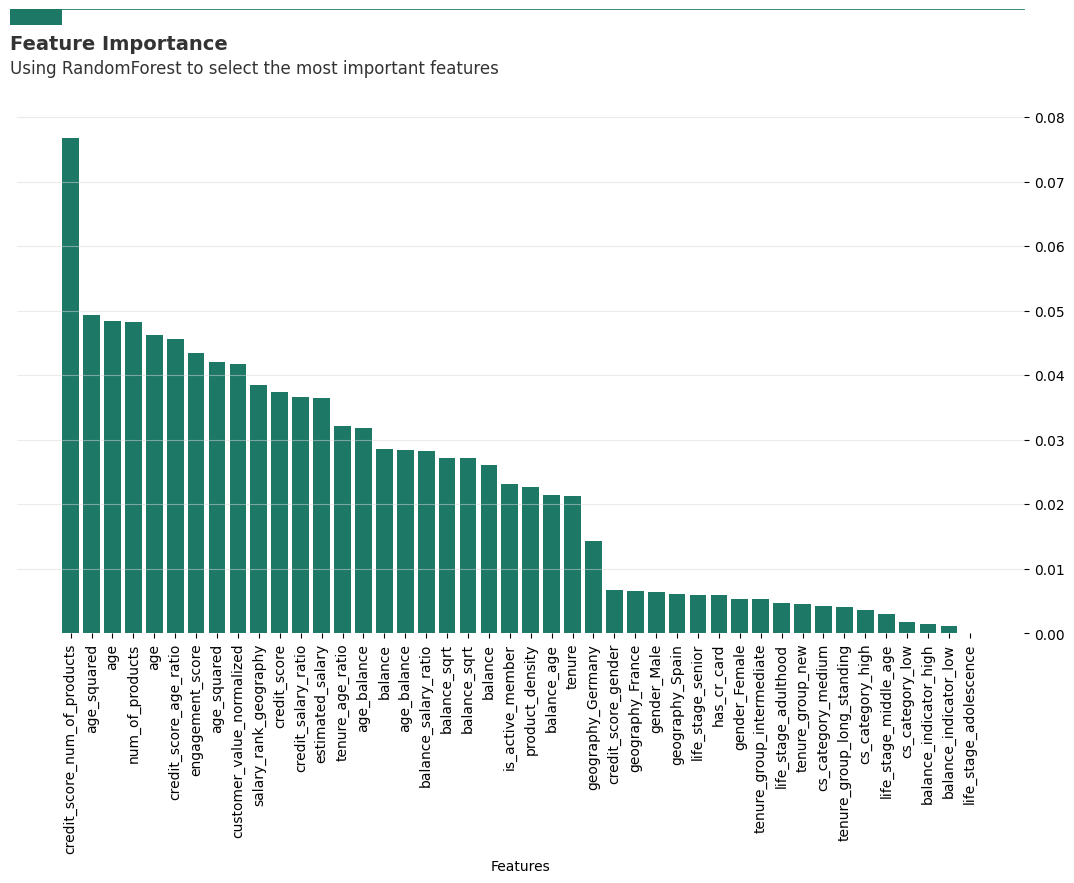

In [27]:
fs_pipeline = FeatureSelection(
    log_list,
    ohe_list,
    standard_scaler_list_c1,
    minmax_scaler_list_c1,
    robust_scaler_list_c1,
)

fs_pipeline.fit(X_train, y_train)
X_transformed = fs_pipeline.transform(X_train)

fs_pipeline.plot_feature_importances()

INFO - Fitting ColumnTransformer
INFO - Fitting Model
INFO - Plotting feature importances


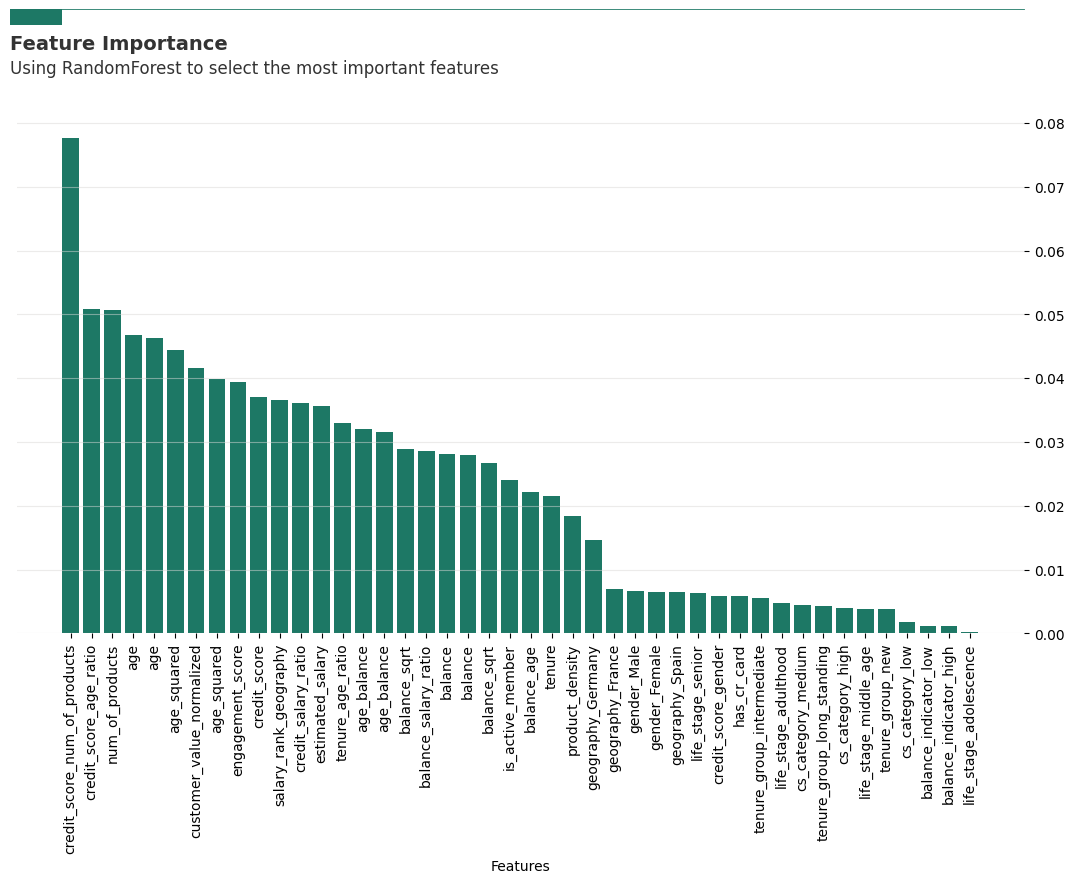

In [28]:
fs_pipeline = FeatureSelection(
    log_list,
    ohe_list,
    standard_scaler_list_c2,
    minmax_scaler_list_c2,
    robust_scaler_list_c2,
)

fs_pipeline.fit(X_train, y_train)
X_transformed = fs_pipeline.transform(X_train)

fs_pipeline.plot_feature_importances()

INFO - Fitting ColumnTransformer
INFO - Fitting Model
INFO - Plotting feature importances


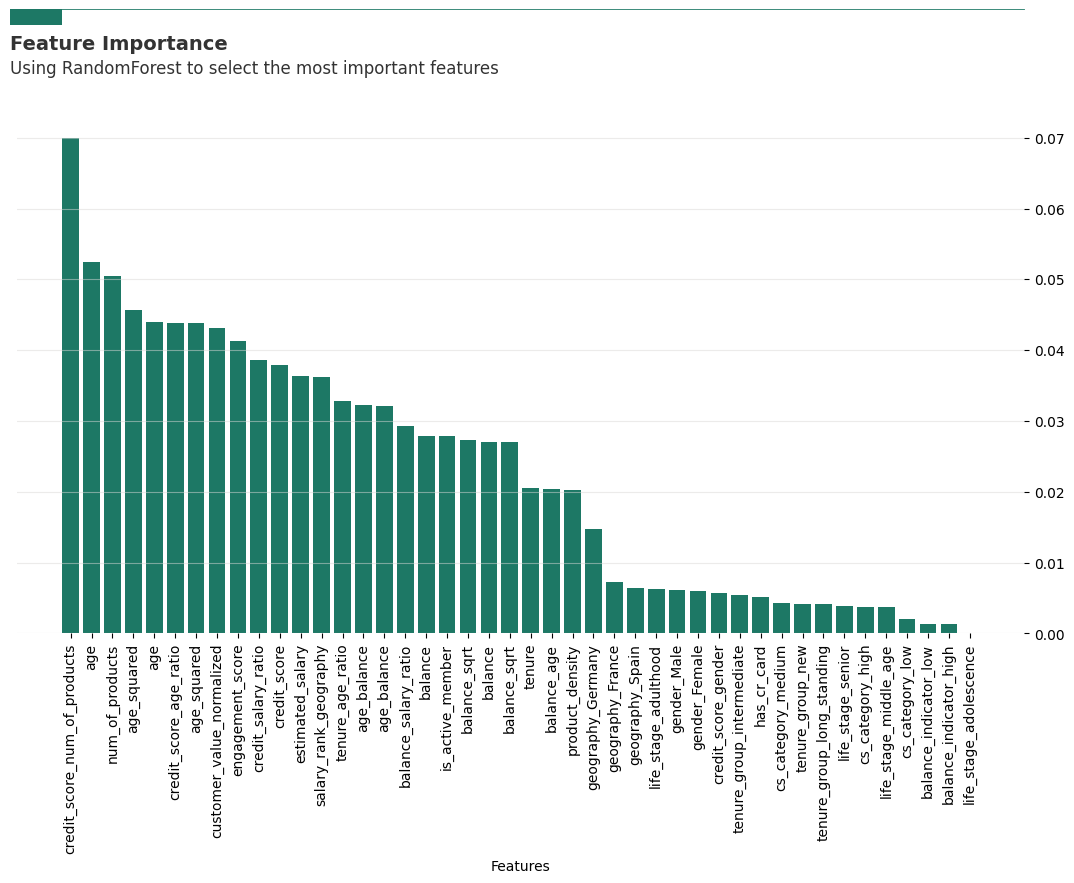

In [29]:
fs_pipeline = FeatureSelection(
    log_list,
    ohe_list,
    standard_scaler_list_c3,
    minmax_scaler_list_c3,
    robust_scaler_list_c3,
)

fs_pipeline.fit(X_train, y_train)
X_transformed = fs_pipeline.transform(X_train)

fs_pipeline.plot_feature_importances()

INFO - Fitting ColumnTransformer
INFO - Fitting Model
INFO - Plotting feature importances


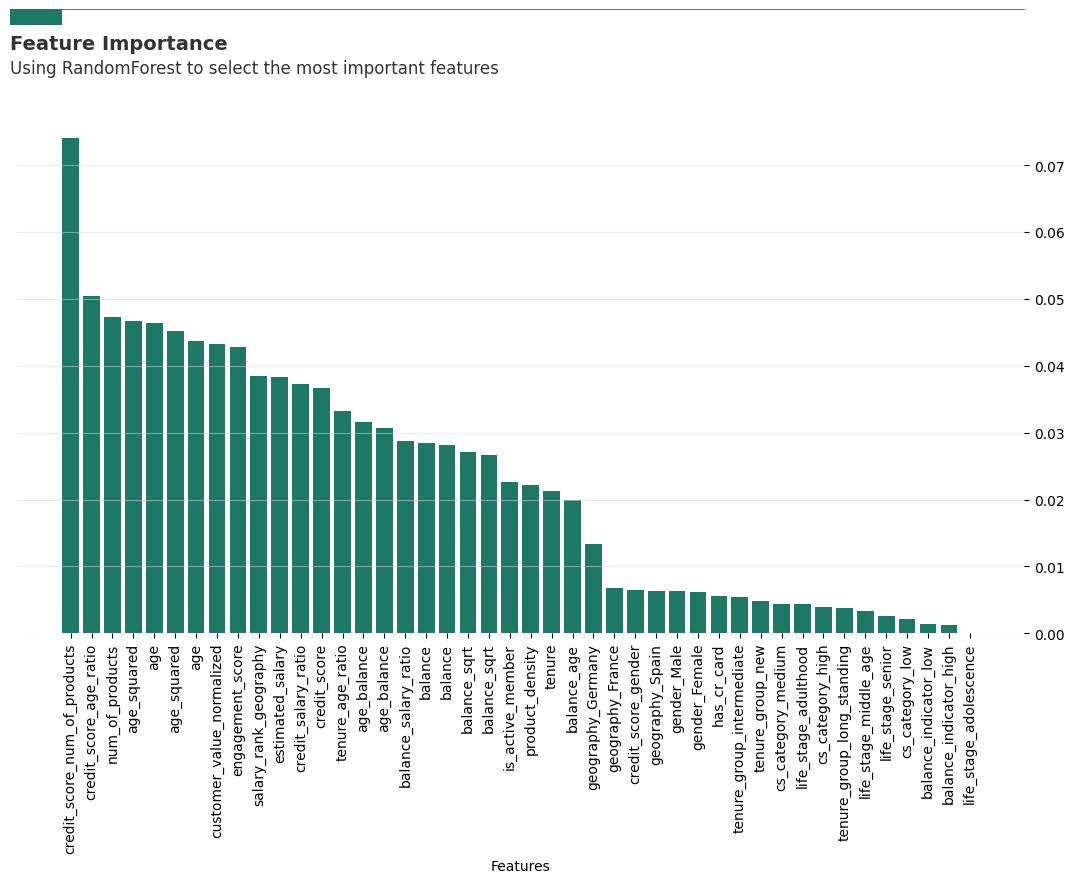

In [30]:
fs_pipeline = FeatureSelection(
    log_list,
    ohe_list,
    standard_scaler_list_c4,
    minmax_scaler_list_c4,
    robust_scaler_list_c4,
)

fs_pipeline.fit(X_train, y_train)
X_transformed = fs_pipeline.transform(X_train)

fs_pipeline.plot_feature_importances()

In [31]:
# from sklearn.ensemble import RandomForestClassifier
# from helpers.classes.MLPipeline import MLPipeline
#
# model = RandomForestClassifier(random_state=seed)
#
## Create an instance of MLPipeline
# pipeline = MLPipeline(X_train, y_train, model)
#
## Build the pipeline with your specific scaling and transformation requirements
# pipeline.build_pipeline(log_list, ohe_list, robust_scaler_list_c1, minmax_scaler_list_c1, standard_scaler_list_c1)
#
## Train the model on the preprocessed data
# model = pipeline.train_model()
# model
#
# pipeline.evaluate_model(X_val, y_val, 0.6)